In [1]:
# This is the step count demo created in the TA hour on 27.03.2023. Check the recording for details
# This is no perfect solution but a basic base-line algorithm which you can use freely and modify. Tweaking the parameters may result in better estimations

In [1]:
import pandas as pd

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join

labels = [101, 101, 102, 101, 52, 47, 43, 61, 49, 75]

#additional packages used for this demo
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

In [2]:
# Get the path of all traces
dir_traces = 'data/labeled_traces'# changed for local dev, original: '/kaggle/input/mobile-health-2023-step-count/data/traces'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()

In [3]:
# this is the whole algorithm wrapped in a function which returns the step count
def step_count_std_thd_wpd(trace):
    acx = np.asarray(trace.data['ax'].values)
    acy = np.asarray(trace.data['ay'].values)
    acz = np.asarray(trace.data['az'].values)
    amag = (acx**2 + acy**2 + acz**2)**0.5

    f = trace.data['ax'].samplerate


    #std_th algorithm to detect walking
    std_win = 0.8 #s
    sigma_thres = 0.08 #g
    std_win_samples = round(std_win*f)

    windowed_data = [amag[s:s+std_win_samples] for s in range(0, len(amag)-std_win_samples, std_win_samples)]
    sigmas = [np.std(dat) for dat in windowed_data]
    sigmas_x = [s+std_win_samples//2 for s in range(0, len(amag)-std_win_samples, std_win_samples)]
    is_walking = [sigma > sigma_thres for sigma in sigmas]
    
    #wpd algorithm to detect walking
    avr_win = 0.31 #s
    peak_win = 0.35 #s

    avr_win_samples = round(avr_win*f)
    peak_win_samples = round(peak_win*f)

    amag_smooth = scipy.ndimage.uniform_filter1d(amag, avr_win_samples, mode='nearest')

    windowed_data_smooth = [amag_smooth[s:s+peak_win_samples] for s in range(0, len(amag_smooth)-peak_win_samples, peak_win_samples)]
    max_indices = np.argmax(windowed_data_smooth, axis=1)
    steps = np.logical_and(max_indices>0, max_indices<peak_win_samples-1)
    
    #merge the two to only preserve steps measured during walking periods
    steps_final = []
    for step_idx, step in enumerate(steps):
        std_th_idx = round((step_idx*peak_win_samples+peak_win_samples//2)/std_win_samples)
        if std_th_idx<len(is_walking) and is_walking[std_th_idx]:
            steps_final.append(step)
        else:
            steps_final.append(False)

    return sum(steps_final)

In [4]:
# Loop through all traces and calculate the step count for each trace
stepCounts = []
ids = []
for fidx, filename in enumerate(filenames[:-1]): # go through all data except for the labels file
    trace = Recording(filename, no_labels=True, mute=True)
    
    stepCount = step_count_std_thd_wpd(trace)  # This is your variable of the step counting that you need to change

    print(filename, "estimate ", stepCount, " ground truth (label) ", labels[fidx])

    # Append your calculated step counts and the id of the trace to the corresponding array
    stepCounts.append(stepCount)
    ids.append(filename.split('_')[1][:2])

data/labeled_traces\labeled_trace_01.json estimate  96  ground truth (label)  101
data/labeled_traces\labeled_trace_02.json estimate  100  ground truth (label)  101
data/labeled_traces\labeled_trace_03.json estimate  83  ground truth (label)  102
data/labeled_traces\labeled_trace_04.json estimate  100  ground truth (label)  101
data/labeled_traces\labeled_trace_05.json estimate  81  ground truth (label)  52
data/labeled_traces\labeled_trace_06.json estimate  47  ground truth (label)  47
data/labeled_traces\labeled_trace_07.json estimate  69  ground truth (label)  43
data/labeled_traces\labeled_trace_08.json estimate  157  ground truth (label)  61
data/labeled_traces\labeled_trace_09.json estimate  69  ground truth (label)  49
data/labeled_traces\labeled_trace_10.json estimate  90  ground truth (label)  75


In [5]:
# the following is the same as in the function for debugging purposes such that we can plot partial results afterwards

filename = filenames[2] # choose the file here
print("doing file ", filename)
trace = Recording(filename, no_labels=True, mute=True)

acx = np.asarray(trace.data['ax'].values)
acy = np.asarray(trace.data['ay'].values)
acz = np.asarray(trace.data['az'].values)
amag = (acx**2 + acy**2 + acz**2)**0.5

f = trace.data['ax'].samplerate


#std_th algorithm to detect walking
std_win = 0.8 #s
sigma_thres = 0.08 #g
std_win_samples = round(std_win*f)

windowed_data = [amag[s:s+std_win_samples] for s in range(0, len(amag)-std_win_samples, std_win_samples)]
sigmas = [np.std(dat) for dat in windowed_data]
sigmas_x = [s+std_win_samples//2 for s in range(0, len(amag)-std_win_samples, std_win_samples)]
is_walking = [sigma > sigma_thres for sigma in sigmas]

#wpd algorithm to detect walking
avr_win = 0.31 #s
peak_win = 0.35 #s

avr_win_samples = round(avr_win*f)
peak_win_samples = round(peak_win*f)

amag_smooth = scipy.ndimage.uniform_filter1d(amag, avr_win_samples, mode='nearest')

windowed_data_smooth = [amag_smooth[s:s+peak_win_samples] for s in range(0, len(amag_smooth)-peak_win_samples, peak_win_samples)]
max_indices = np.argmax(windowed_data_smooth, axis=1)
steps_x = [s+peak_win_samples//2 for s in range(0, len(amag)-peak_win_samples, peak_win_samples)]
steps = np.logical_and(max_indices>0, max_indices<peak_win_samples-1)

#merge the two
steps_final = []
for step_idx, step in enumerate(steps):
    std_th_idx = round((step_idx*peak_win_samples+peak_win_samples//2)/std_win_samples)
    if std_th_idx<len(is_walking) and is_walking[std_th_idx]:
        steps_final.append(step)
    else:
        steps_final.append(False)
sum(steps_final)

doing file  data/labeled_traces\labeled_trace_03.json


83

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
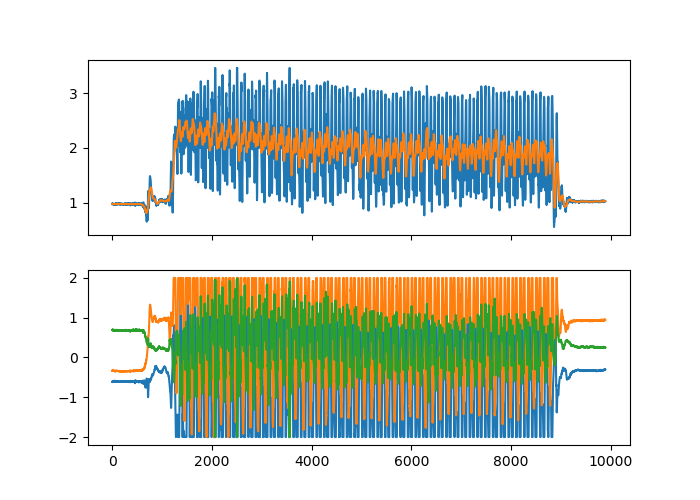

In [8]:
# make the plot interactive (to reverse use %matplotlib inline)
%matplotlib widget 

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
ax[0].plot(amag)
ax[0].plot(amag_smooth)
#ax[0].plot(sigmas_x, sigmas)
#ax[0].plot(sigmas_x, is_walked)

ax[1].plot(acx)
ax[1].plot(acy)
ax[1].plot(acz)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
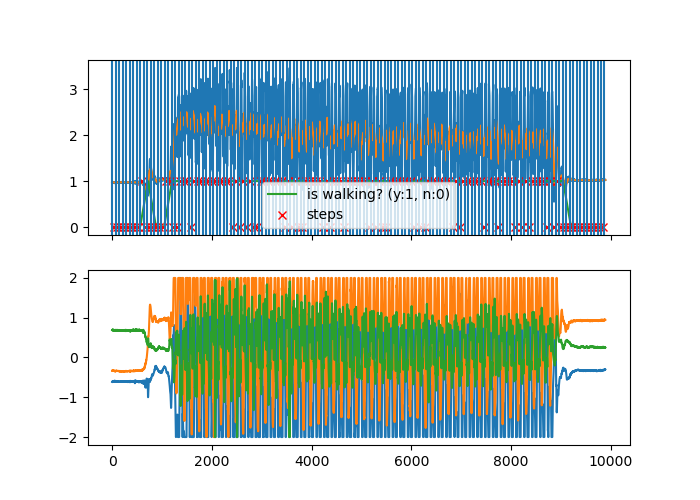

In [7]:
# make the plot interactive (to reverse use %matplotlib inline)
%matplotlib widget

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
ax[0].plot(amag)
ax[0].plot(amag_smooth)
#ax[0].plot(sigmas_x, sigmas)
ax[0].plot(sigmas_x, is_walking, label="is walking? (y:1, n:0)")
ax[0].plot(steps_x, steps_final, 'rx', label="steps")

for s in  range(0, len(amag), peak_win_samples): # adding vertical lines for the peak detection windows
    ax[0].axvline(s)


ax[0].legend()
ax[1].plot(acx)
ax[1].plot(acy)
ax[1].plot(acz)

plt.show()
